# Load and plot results from eval script runs

In [37]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from pprint import pprint

In [58]:
res_file_path = (
    "/Users/szepi1991/Code/adaptive_time/code/adaptive_time/tradeoff_results_20240227-151731.pkl"
)


with open(res_file_path, "rb") as f:
    loaded = pickle.load(f)
    if "results" in loaded:
        results = loaded["results"]
        print("The config for these results was: ")
        pprint(loaded["config"])
    else:
        results = loaded
        print("Could not find a config.")

The config for these results was: 
{'budget': 1000,
 'budget_type': <BudgetType.UPDATES: 2>,
 'epsilon': 0.0,
 'gamma': 0.99999,
 'max_env_steps': None,
 'num_runs': 2,
 'save_limit': None,
 'seed': 13,
 'tau': 0.002,
 'termination_prob': 0,
 'weights_to_evaluate': 0}


In [72]:
results.keys()

dict_keys(['q0_10', 'q0_5', 'q0_1', 'u5', 'u10', 'u20'])

In [76]:
print("number of runs:", len(results['q0_10']))

number of runs: 2


In [82]:
print("recorded stats:")
pprint(list(results['q0_10'][0].keys()))

recorded stats:
['total_return',
 'total_pivots',
 'total_interactions',
 'num_episode',
 'returns_per_episode_q',
 'predicted_returns_q',
 'returns_per_episode_v',
 'predicted_returns_v']


The following is only true if we used an interaction budget. If we
used an update budget, we can run some methods longer.

Let's do a minor sanity check. Since we used no randomness (?), ALL
runs should have the same number of episodes, and each corresponding
episode should have the same number of interactions.

In [84]:
print("Numbers of episodes:")
for name, runs_data in results.items():
    num_episodes = [len(run["returns_per_episode_v"]) for run in runs_data]
    print(f" * {name}: {num_episodes}")

Numbers of episodes:
 * q0_10: [62, 63]
 * q0_5: [54, 55]
 * q0_1: [33, 32]
 * u5: [16, 15]
 * u10: [30, 30]
 * u20: [55, 59]


In [85]:
def plot_stuff(tuples_of_x_y_labels_kwargs, title, ylabel, show):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for x, y, label, kwargs in tuples_of_x_y_labels_kwargs:
        plt.plot(x, y, label=label, **kwargs)

    plt.ylabel(ylabel, rotation=0, labelpad=40)
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax


dict_keys(['q0_10', 'q0_5', 'q0_1', 'u5', 'u10', 'u20'])

In [61]:
pprint(list(results["q0_10"][0].keys()))

['total_return',
 'total_pivots',
 'total_interactions',
 'num_episode',
 'returns_per_episode_q',
 'predicted_returns_q',
 'returns_per_episode_v',
 'predicted_returns_v']


In [62]:
pprint(np.stack(results["q0_10"][0]["predicted_returns_v"]))

array([313.68140762, 313.67944155, 291.00547066, 290.99283633,
       290.94322949, 285.93048857, 271.78533   , 273.42201715,
       271.49836876, 267.46821271, 294.02323372, 293.98645065,
       297.26469498, 297.26032009, 311.2615684 , 340.34123871,
       340.34728919, 340.33400217, 331.44332544, 331.35933844,
       321.83563756, 321.80527893, 318.63214191, 317.72537056,
       365.55603951, 359.77480934, 359.65115804, 359.17527288,
       359.17957826, 359.16143108, 359.12792207, 359.12319653,
       351.88870111, 352.50978883, 351.94234838, 351.93584379,
       351.24295373, 350.27376925, 357.29027534, 357.24119564,
       351.93314943, 356.71512485, 356.73707386, 356.69821558,
       356.93793046, 356.93119938, 353.08444574, 349.80705058,
       349.41885079, 349.37966773, 353.22445846, 348.75480169,
       365.45376865, 361.79645941, 360.85445736, 365.05594398,
       365.05086438, 361.71394645, 374.14087218, 371.32257934,
       368.29418601, 366.0546919 ])


In [65]:
# def pad_along_axis(
#         array: np.ndarray, target_length: int, axis: int = 0, pad_value=0.0
# ) -> np.ndarray:

#     pad_size = target_length - array.shape[axis]

#     if pad_size <= 0:
#         return array

#     npad = [(0, 0)] * array.ndim
#     npad[axis] = (0, pad_size)

#     return np.pad(
#         array, pad_width=npad, mode='constant', constant_values=pad_value)


def pad_combine(list_of_vecs, pad_value=np.nan):
    # print("original shapes")
    # for p in list_of_vecs:
    #     print(p.shape)

    max_len = max([len(v) for v in list_of_vecs])
    padded = [
        np.pad(v, (0, max_len - len(v)), mode='constant', constant_values=pad_value)
        # pad_along_axis(v, max_len, axis=0, pad_value=pad_value)
        for v in list_of_vecs
    ]
    # print("padded shapes")
    # for p in padded:
    #     print(p.shape)
    # print("---")
    return np.stack(padded, axis=1)

In [67]:
preds_per_method = {}   # nethod -> [traj_len, n_runs] of pred Vs
rets_per_method = {}     # nethod -> [traj_len, n_runs] of est Vs
for name in results.keys():
    # print("=== processing ", name)
    preds_per_method[name] = pad_combine([
        np.array(run["predicted_returns_v"])
        for run in results[name]
    ])
    rets_per_method[name] = pad_combine([
        np.array(run["returns_per_episode_v"])
        for run in results[name]
    ])

# At this point, we combined all runs of each method into
# a single array of shape [traj_len, n_runs]


## Plots of Average Behaviour

In [ ]:
# results = results[0]


# plot_est_vs_pred([
#    (average_returns, 'Empirical Returns', {}),
#    (predicted_returns, 'Predicted Returns', {})],
#    title='Empirical vs Predicted Returns')


## Plots of individual runs

### Plot of sample returns -- by episodes

Since we are doing evaluation and there is no randomness at this point,
these should be the same accross all runs and all methods!

In [70]:
for row in rets_per_method["q0_10"].T:
    print(row.shape)

(63,)
(63,)


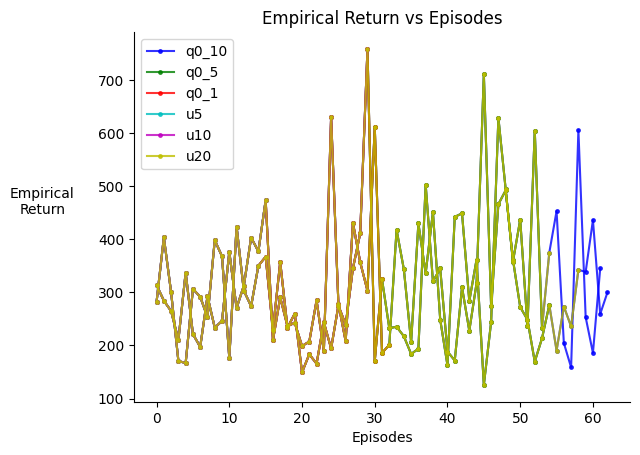

In [88]:

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

tuples_of_y_labels_kwargs = []
for i, (name, array_of_runs) in enumerate(rets_per_method.items()):
    for r_idx, est_rets in enumerate(array_of_runs.T):
        tuples_of_y_labels_kwargs.append((
            list(range(len(est_rets))),
            est_rets,
            name if r_idx==0 else None,
            # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
            {"color": colors[i], "marker": ".", "linestyle": "-",
             "markersize": 5, "alpha": 0.8}
        ))

ax = plot_stuff(
    tuples_of_y_labels_kwargs, "Empirical Return vs Episodes",
    "Empirical\nReturn" ,False)
# ax.set_yscale('log')
ax.set_xlabel('Episodes')
plt.show()



It is kind of surprising at first that some go longer than others. It's because we ran with an update budget and some methods make fewer updates per episode.